In [1]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971, 20006114, 20006007, 20006618
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Import dataset
df = pd.read_csv('./dataset.csv')

df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True) # drop unnamed column
df.dropna(inplace=True) # drop rows with null values

df['valence'] = df['valence'].astype('category')
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1) # sets valence to 0 if sad, 1 if happy

# Convert 'explicit' boolean to integer (0/1)
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Scalar
scalar = StandardScaler()

# X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
X = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'valence'], axis=1)
y = df['valence']

X = pd.DataFrame(scalar.fit_transform(X), columns=X.columns)

# Get a random number for the random_state variable
import random
random_state = random.randint(1, 100)

# Train the code
attr_train, attr_test, target_train, target_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

print(df.head(1))

target_train.head()
# attr_train.head()
target_test.head()

                 track_id      artists album_name track_name  popularity  \
0  5SuOikwiRyPMVoIQDJUgSV  Gen Hoshino     Comedy     Comedy          73   

   duration_ms  explicit  danceability  energy  loudness  ...  \
0       230666         0         0.676   0.461    -6.746  ...   

   track_genre_spanish  track_genre_study  track_genre_swedish  \
0                False              False                False   

   track_genre_synth-pop  track_genre_tango  track_genre_techno  \
0                  False              False               False   

   track_genre_trance  track_genre_trip-hop  track_genre_turkish  \
0               False                 False                False   

   track_genre_world-music  
0                    False  

[1 rows x 145 columns]


70758    0
6968     0
48266    0
95341    1
13541    1
Name: valence, dtype: int64

In [4]:
# Train Naive Bayes model
model = GaussianNB()
model.fit(attr_train, target_train)

# Make Prediction
target_pred = model.predict(attr_test)

In [5]:
# Evaluate model
accuracy = accuracy_score(target_test, target_pred)
conf_matrix = confusion_matrix(target_test, target_pred)
class_report = classification_report(target_test, target_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6881

Confusion Matrix:
 [[12210  6403]
 [ 4265 11322]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70     18613
           1       0.64      0.73      0.68     15587

    accuracy                           0.69     34200
   macro avg       0.69      0.69      0.69     34200
weighted avg       0.69      0.69      0.69     34200



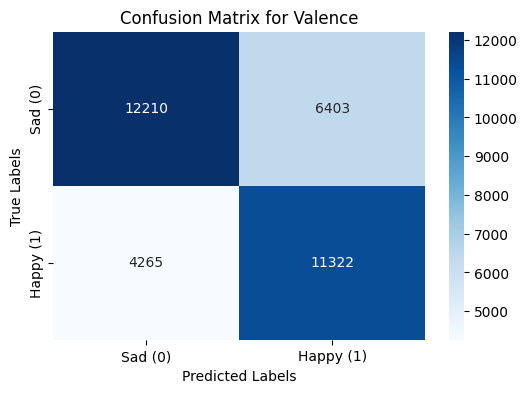

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(target_test, target_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()

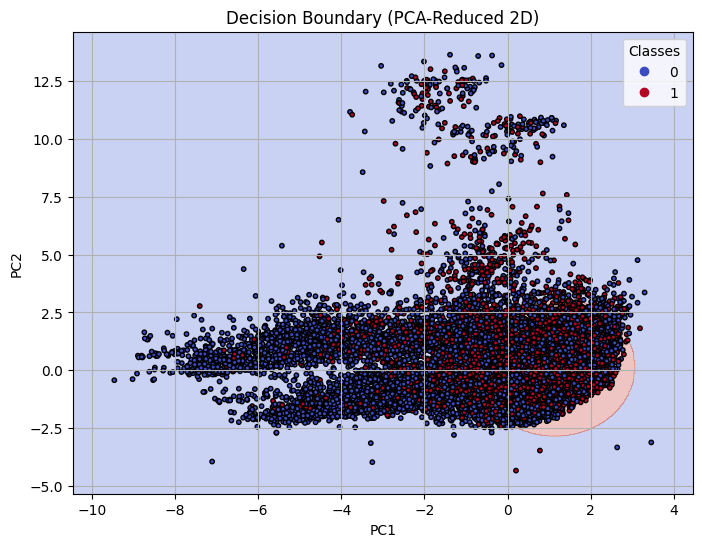

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA and model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(attr_train)
X_test_scaled = scaler.transform(attr_test)

# Reduce to 2D with PCA for visualization
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)
X_test_2D = pca.transform(X_test_scaled)

# Retrain model on reduced features
gaussianNB_retrain = GaussianNB()
gaussianNB_retrain.fit(X_train_2D, target_train)


# Plotting
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in mesh

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", s=10, cmap=plt.cm.coolwarm)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Decision Boundary (PCA-Reduced 2D)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


# Plot
plot_decision_boundary(gaussianNB_retrain, X_test_2D, target_test)